In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [62.9 kB]
Ign:13 https://developer.download.nv

In [2]:
# First, enter the following code to download a Postgres driver that will allow Spark to interact with Postgres:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-08-02 06:32:46--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  6.02MB/s    in 0.2s    

2021-08-02 06:32:47 (6.02 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Final_data").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://tq2cutebucket.s3.us-west-1.amazonaws.com/final_data.csv"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("final_data.csv"), sep=",", header=True, inferSchema=True)
df.show()

+------------+--------------------+------------+--------+--------------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
|  MLS_Number|      Street_Address|        City|Zip_Code|        county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_List|Year_Sold|List_Price|Sale_Price|  Listing_Date|     Sale_Date|Year_Built|
+------------+--------------------+------------+--------+--------------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
|  BE40950609|   2724 Foxglove Ct |  Pleasanton|   94588|       Alameda|           8|     2051|  2949.0| 23|         3|        4|        2|        1|  6|     2021|     2021|   1450000|   1625000|5/19/2021 0:00|5/25/2021 0:00|      1998|
|  ML81845215|  7873 Chestnut WAY |  Pleasanton|   9

In [5]:
df = df.select('county','County_Index','SqFtTotal','Lot_Size', 'BedsTotal','BathsTotal',"Age",'Year_Built','DOM','Year_Sold','Sale_Price')
data_df = df.filter("County_Index = 1")
data_df.dtypes
data_df.count()

419

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [7]:
data_array = np.array(data_df.collect())

In [8]:
X = data_array[0:419,1:10]
y = data_array[0:419,10:11]
print(X)
print(y)

[['1' '2389' '6098.0' ... '2014' '6' '2021']
 ['1' '2250' '4356.0' ... '2003' '0' '2021']
 ['1' '1834' '6098.0' ... '1987' '3' '2021']
 ...
 ['1' '2636' '9148.0' ... '2012' '1' '2021']
 ['1' '1542' '4792.0' ... '1996' '7' '2021']
 ['1' '2586' '5663.0' ... '2015' '6' '2021']]
[['800000']
 ['775000']
 ['511000']
 ['540000']
 ['540000']
 ['740000']
 ['675000']
 ['560000']
 ['765000']
 ['735000']
 ['545000']
 ['506000']
 ['445000']
 ['520000']
 ['395000']
 ['730000']
 ['650000']
 ['710000']
 ['610000']
 ['560000']
 ['370000']
 ['180000']
 ['900000']
 ['375000']
 ['610000']
 ['635000']
 ['2700000']
 ['310000']
 ['900000']
 ['661000']
 ['845000']
 ['430000']
 ['590000']
 ['450000']
 ['282000']
 ['607000']
 ['546000']
 ['495000']
 ['450000']
 ['465000']
 ['535000']
 ['630000']
 ['1660000']
 ['435000']
 ['565000']
 ['415900']
 ['790000']
 ['735000']
 ['420000']
 ['455000']
 ['1200000']
 ['560000']
 ['505000']
 ['580000']
 ['1500000']
 ['655000']
 ['388500']
 ['430000']
 ['350000']
 ['550000']


In [9]:
#your_array = your_array.astype(np.float64)
X = X.astype(np.float64)
y = y.astype(np.float64)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(398, 9) (21, 9) (398, 1) (21, 1)


In [12]:
# Fit ML Regression to a traing set
# Note: intercept is set to zero
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(X_train, y_train)

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
# Predicting the test result
y_pred = regression.predict(X_test)

In [14]:
# Print out the coefficents
print(regression.coef_)

[[ 0.00000000e+00  2.34694555e+02  2.68857098e+00 -3.13283215e+04
   2.75191985e+04  1.08161553e+03 -1.08161553e+03  2.63015595e+02
   5.66038424e+04]]


In [15]:
# Print out the interceptor
print(regression.intercept_)

[-1.12173113e+08]


In [16]:
# R squared
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.23196557842444854

In [17]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

21270596620.03321

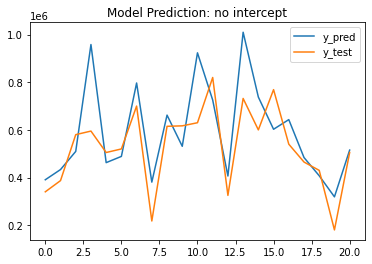

In [18]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test)
plt.title('Model Prediction: no intercept')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
plt.legend(['y_pred', 'y_test'], loc='upper right')
plt.show()

In [19]:
# Fit ML Regression to a traing set
# Note: intercept is not restricted
from sklearn.linear_model import LinearRegression
regression2 = LinearRegression(fit_intercept=True)
regression2.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
# Predicting the test result
y_pred2 = regression2.predict(X_test)

In [21]:
# Print out the coefficents
print(regression2.coef_)

[[ 0.00000000e+00  2.34694555e+02  2.68857098e+00 -3.13283215e+04
   2.75191985e+04  1.08161553e+03 -1.08161553e+03  2.63015595e+02
   5.66038424e+04]]


In [22]:
# Print out the interceptor
print(regression.intercept_)

[-1.12173113e+08]


In [23]:
# R squared
from sklearn.metrics import r2_score
r2_int = r2_score(y_test, y_pred2)
r2_int

0.23196557842444854

**With an intercept**, the R squared is also 0.62 or 62%

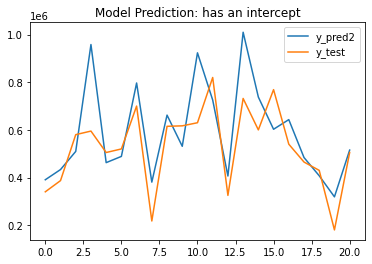

In [24]:
import matplotlib.pyplot as plt
plt.plot(y_pred2)
plt.plot(y_test)
plt.title('Model Prediction: has an intercept')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
plt.legend(['y_pred2', 'y_test', 'r2_int'], loc='upper right')
plt.show()

**END**